**10x Genomics 4 health donor data preporcessing**
- [download 10x data](https://www.10xgenomics.com/datasets?query=A%20New%20Way%20of%20Exploring%20Immunity&menu%5Bproducts.name%5D=Single%20Cell%20Immune%20Profiling&page=1&configure%5BhitsPerPage%5D=50&configure%5BmaxValuesPerFacet%5D=1000)

**Preprocessing pipeline (optional)**
1. Read and prepare adata 
2. Quality control (Scanpy pipeline)         
3. Cell and gene filtering  
4. Doublet detection (optional)
5. Normalization         
6. HVGs selection    
(do not scale data, preserve the bio-singals between donors)
7. Filter cells with single paired TCRs
8. Clonotype annotation
9. Tokenize amino acid sequence with ESM tokenizer
9. Add antigen binding info
10. Train-val-test split (optional)
11. Add antigen binding labels of major pMHC
12. Add avidity info

**Packages dependencies**
- scirpy 0.22.3 (must after 0.13.1)
- srublet 0.2.3
- scanpy 1.9.8

**Select ESM tokens or random initalization**
- [ESM tokenizer](https://github.com/huggingface/transformers/blob/v4.53.3/src/transformers/models/esm/tokenization_esm.py#L35)


In [1]:
import os,sys
sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..')))
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import scanpy as sc
import scirpy as ir
import pandas as pd
import numpy as np
import awkward as ak
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=70)
sc.settings.n_jobs = 3
sc.set_figure_params(vector_friendly=True,color_map='viridis',dpi_save=600,transparent=True)

In [2]:
import vqtcr as vq
path_base = '/mnt/d/Dataset/vqTCR/10XGenomics/'
path_merged = path_base + 'merged_tcr_10X_airr.h5ad'
path_filtered = path_base + 'filtered_tcr_10X_airr.h5ad'
path_logged = path_base + 'logged+10X_airr.h5ad'
path_hvg = path_base + 'hvg_5000_airr.h5ad'
path_token = path_base + 'aa_token_airr.h5ad'
path_clean_split = path_base + 'split_esm_airr.h5ad'
path_supervised = path_base + 'supervised_esm_airr.h5ad'
path_avidity = path_base + 'avidity_esm_airr.h5ad'

**Read and prepare adata**
- merge GEX and TCR
- merge all donor
- merge binding affinity

In [3]:
adatas = []
batch_names = []
for i in range(1,5):
    # RNA
    file_name = path_base + f'donor{i}/vdj_v1_hs_aggregated_donor{i}_filtered_feature_bc_matrix.h5'
    adata_tmp = sc.read_10x_h5(file_name)
    
    # TCR
    path_anno = path_base + f'donor{i}/vdj_v1_hs_aggregated_donor{i}_all_contig_annotations.csv'
    adata_tcr = ir.io.read_10x_vdj(path_anno)
    
    # Align cells with shared barcodes
    barcode2idx = {barcode: i for i, barcode in enumerate(adata_tcr.obs_names)}
    idx = [barcode2idx.get(barcode) for barcode in adata_tmp.obs_names]
    
    #Remove all cells without tcr annotation
    adata_tmp.obsm["airr"] = adata_tcr.obsm["airr"][idx]
    adata_tmp = adata_tmp[~ak.is_none(adata_tmp.obsm['airr']).to_numpy()]

    # pMHC Binding
    path_binding = path_base + f'donor{i}/vdj_v1_hs_aggregated_donor{i}_binarized_matrix.csv'
    binarized_matrix = pd.read_csv(path_binding, sep=',', header=0)
    
    for k in binarized_matrix.columns:
        adata_tmp.obs[k] = None
        adata_tmp.obs.loc[binarized_matrix['barcode'].values, k] = binarized_matrix[k].values
        adata_tmp.obs[k] = adata_tmp.obs[k].astype(str)
        
    adata_tmp.var_names_make_unique()
    adatas.append(adata_tmp)
    batch_names.append(f'donor_{i}')

adata = adatas[0].concatenate(adatas[1:], batch_key='donor', batch_categories=batch_names)

for c in adata.obs.columns:
    if c.startswith('CD') or c.startswith('Ig') or c.startswith('HLA'):
        adata.obs[c] = adata.obs[c].astype(str)
sc.write(adata=adata, filename=path_merged)

reading /mnt/d/Dataset/vqTCR/10XGenomics/donor1/vdj_v1_hs_aggregated_donor1_filtered_feature_bc_matrix.h5
 (0:00:03)
reading /mnt/d/Dataset/vqTCR/10XGenomics/donor2/vdj_v1_hs_aggregated_donor2_filtered_feature_bc_matrix.h5
 (0:00:05)
reading /mnt/d/Dataset/vqTCR/10XGenomics/donor3/vdj_v1_hs_aggregated_donor3_filtered_feature_bc_matrix.h5
 (0:00:03)
reading /mnt/d/Dataset/vqTCR/10XGenomics/donor4/vdj_v1_hs_aggregated_donor4_filtered_feature_bc_matrix.h5
 (0:00:01)


In [4]:
print(adata)
print(adata.obs['donor'].value_counts())

AnnData object with n_obs × n_vars = 190425 × 33538
    obs: 'barcode', 'donor', 'cell_clono_cdr3_aa', 'cell_clono_cdr3_nt', 'CD3', 'CD19', 'CD45RA', 'CD4', 'CD8a', 'CD14', 'CD45RO', 'CD279_PD-1', 'IgG1', 'IgG2a', 'IgG2b', 'CD127', 'CD197_CCR7', 'HLA-DR', 'A0101_VTEHDTLLY_IE-1_CMV', 'A0201_KTWGQYWQV_gp100_Cancer', 'A0201_ELAGIGILTV_MART-1_Cancer', 'A0201_CLLWSFQTSA_Tyrosinase_Cancer', 'A0201_IMDQVPFSV_gp100_Cancer', 'A0201_SLLMWITQV_NY-ESO-1_Cancer', 'A0201_KVAELVHFL_MAGE-A3_Cancer', 'A0201_KVLEYVIKV_MAGE-A1_Cancer', 'A0201_CLLGTYTQDV_Kanamycin-B-dioxygenase', 'A0201_LLDFVRFMGV_EBNA-3B_EBV', 'A0201_LLMGTLGIVC_HPV-16E7_82-91', 'A0201_CLGGLLTMV_LMP-2A_EBV', 'A0201_YLLEMLWRL_LMP1_EBV', 'A0201_FLYALALLL_LMP2A_EBV', 'A0201_GILGFVFTL_Flu-MP_Influenza', 'A0201_GLCTLVAML_BMLF1_EBV', 'A0201_NLVPMVATV_pp65_CMV', 'A0201_ILKEPVHGV_RT_HIV', 'A0201_FLASKIGRLV_Ca2-indepen-Plip-A2', 'A2402_CYTWNQMNL_WT1-(235-243)236M_Y', 'A0201_RTLNAWVKV_Gag-protein_HIV', 'A0201_KLQCVDLHV_PSA146-154', 'A0201_LLFGYPVYV

**Quality control**

In [5]:
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log10(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
mt_gene_index = np.where(mt_gene_mask)[0]
adata.obs['mt_fraction'] = adata.X[:, mt_gene_index].sum(1) / adata.X.sum(1)

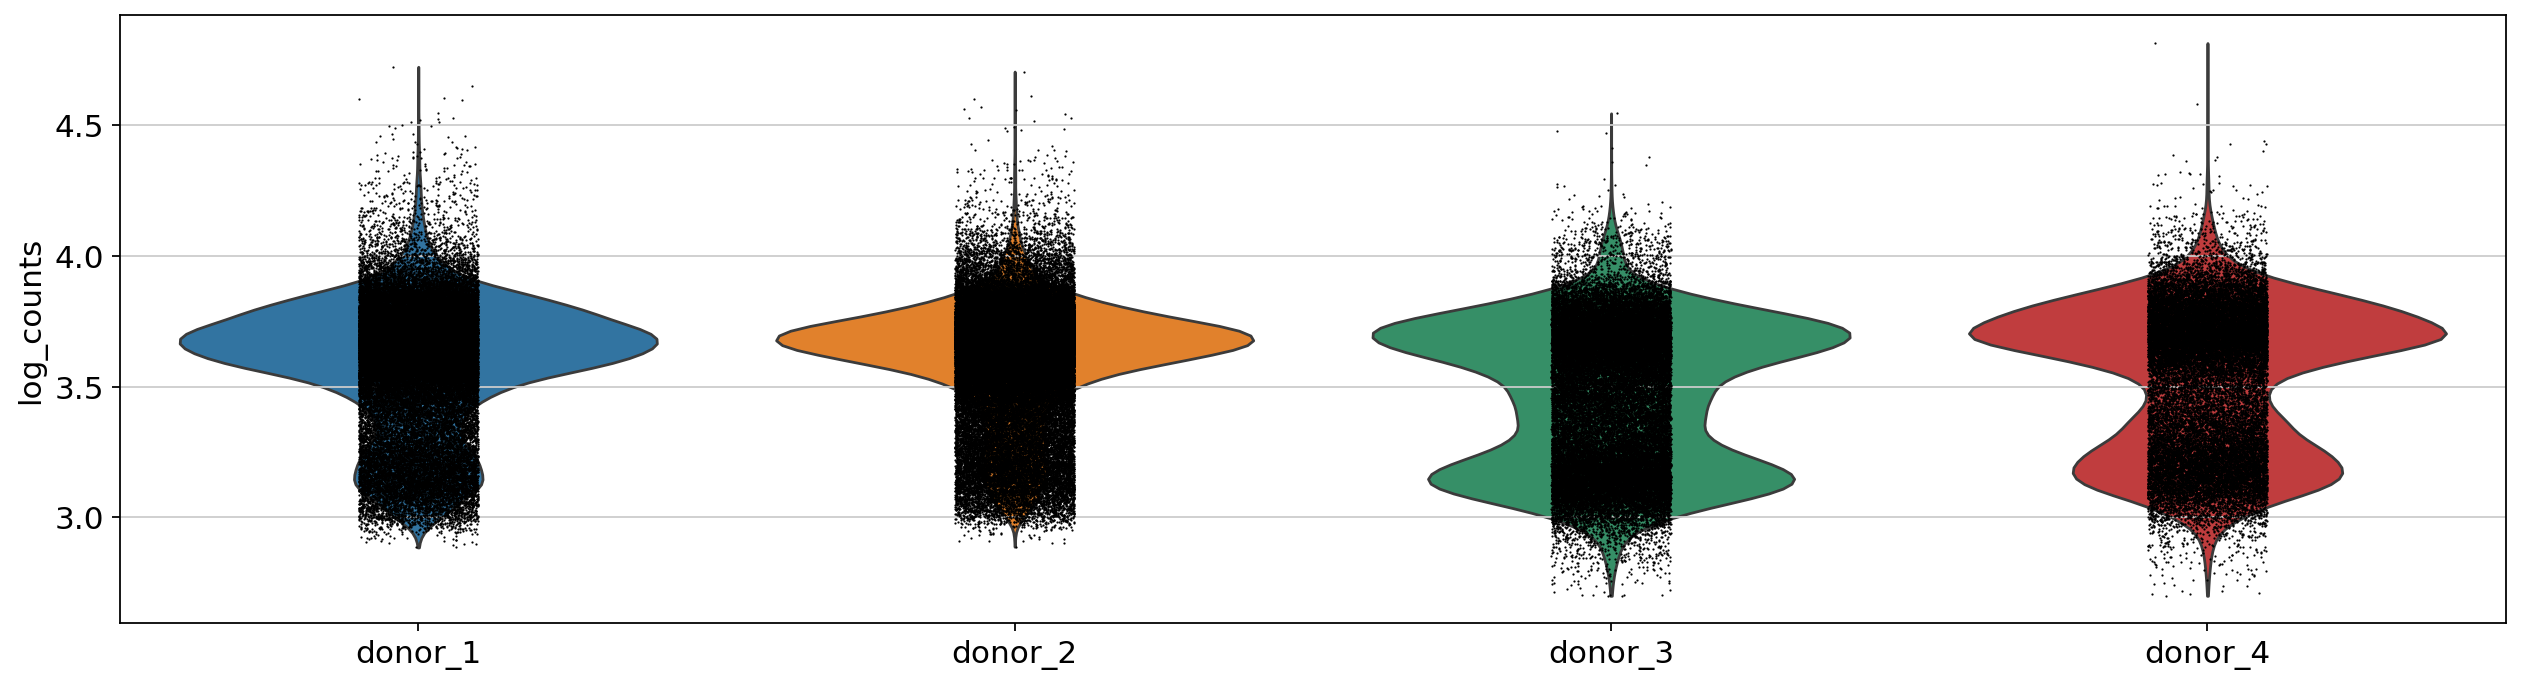

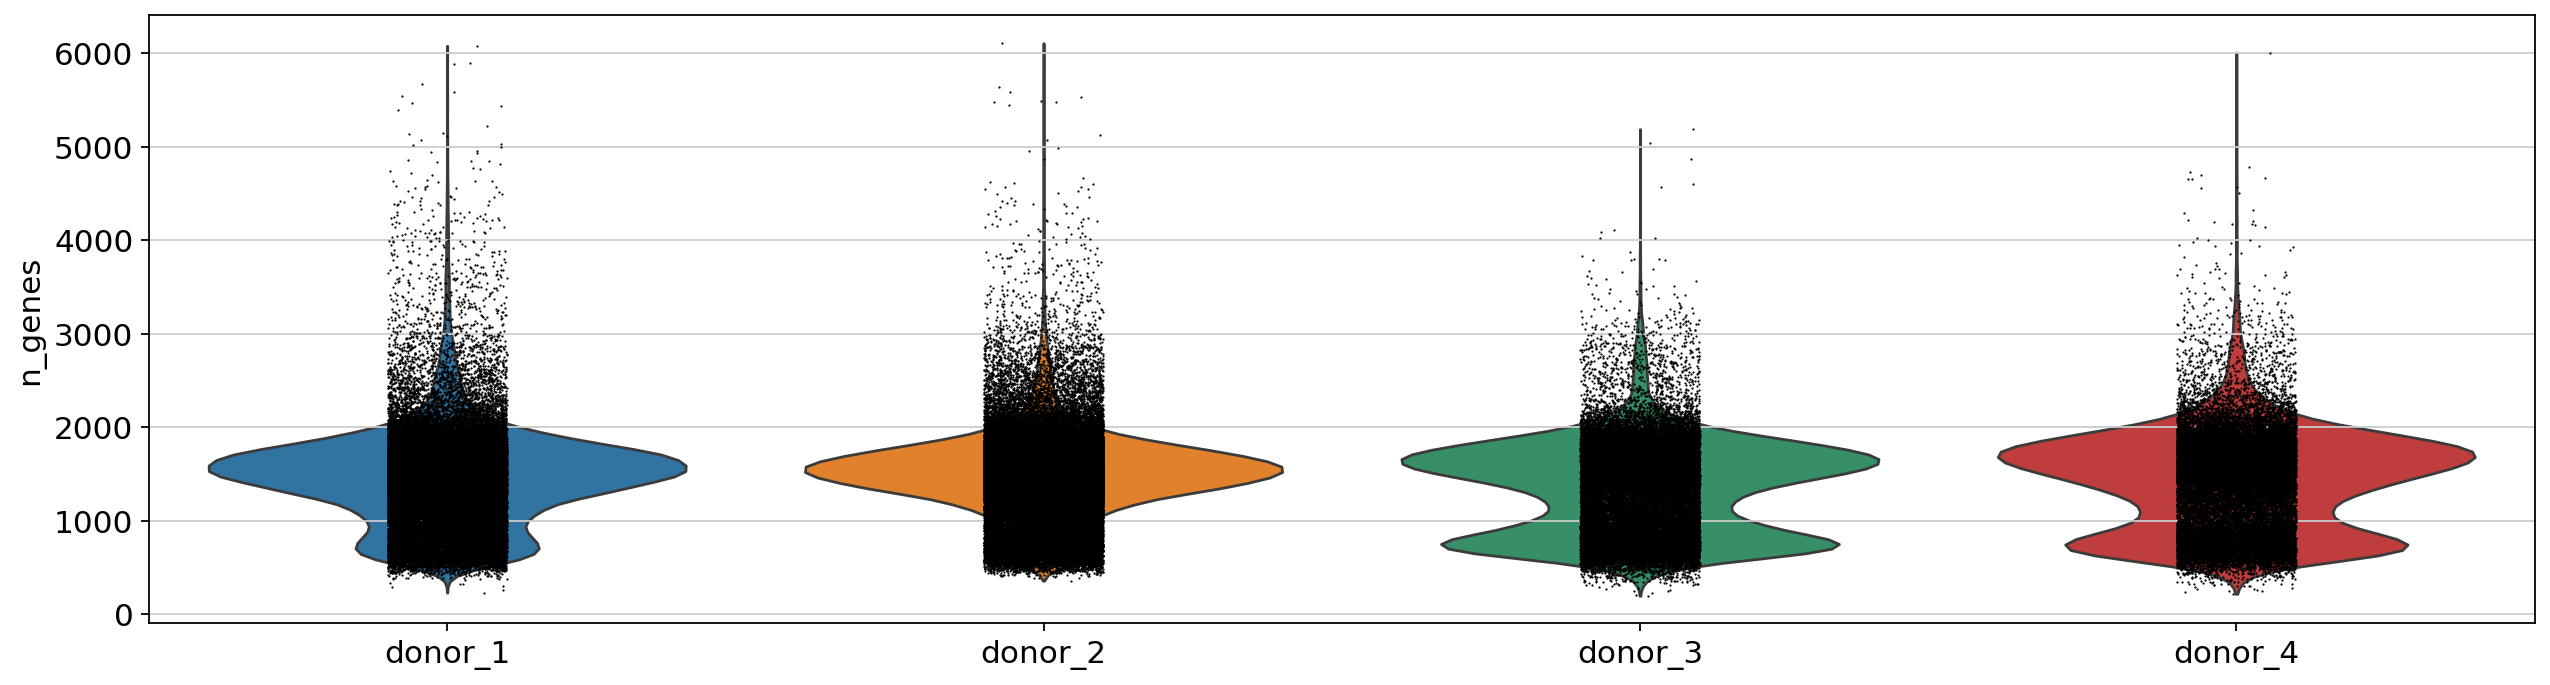

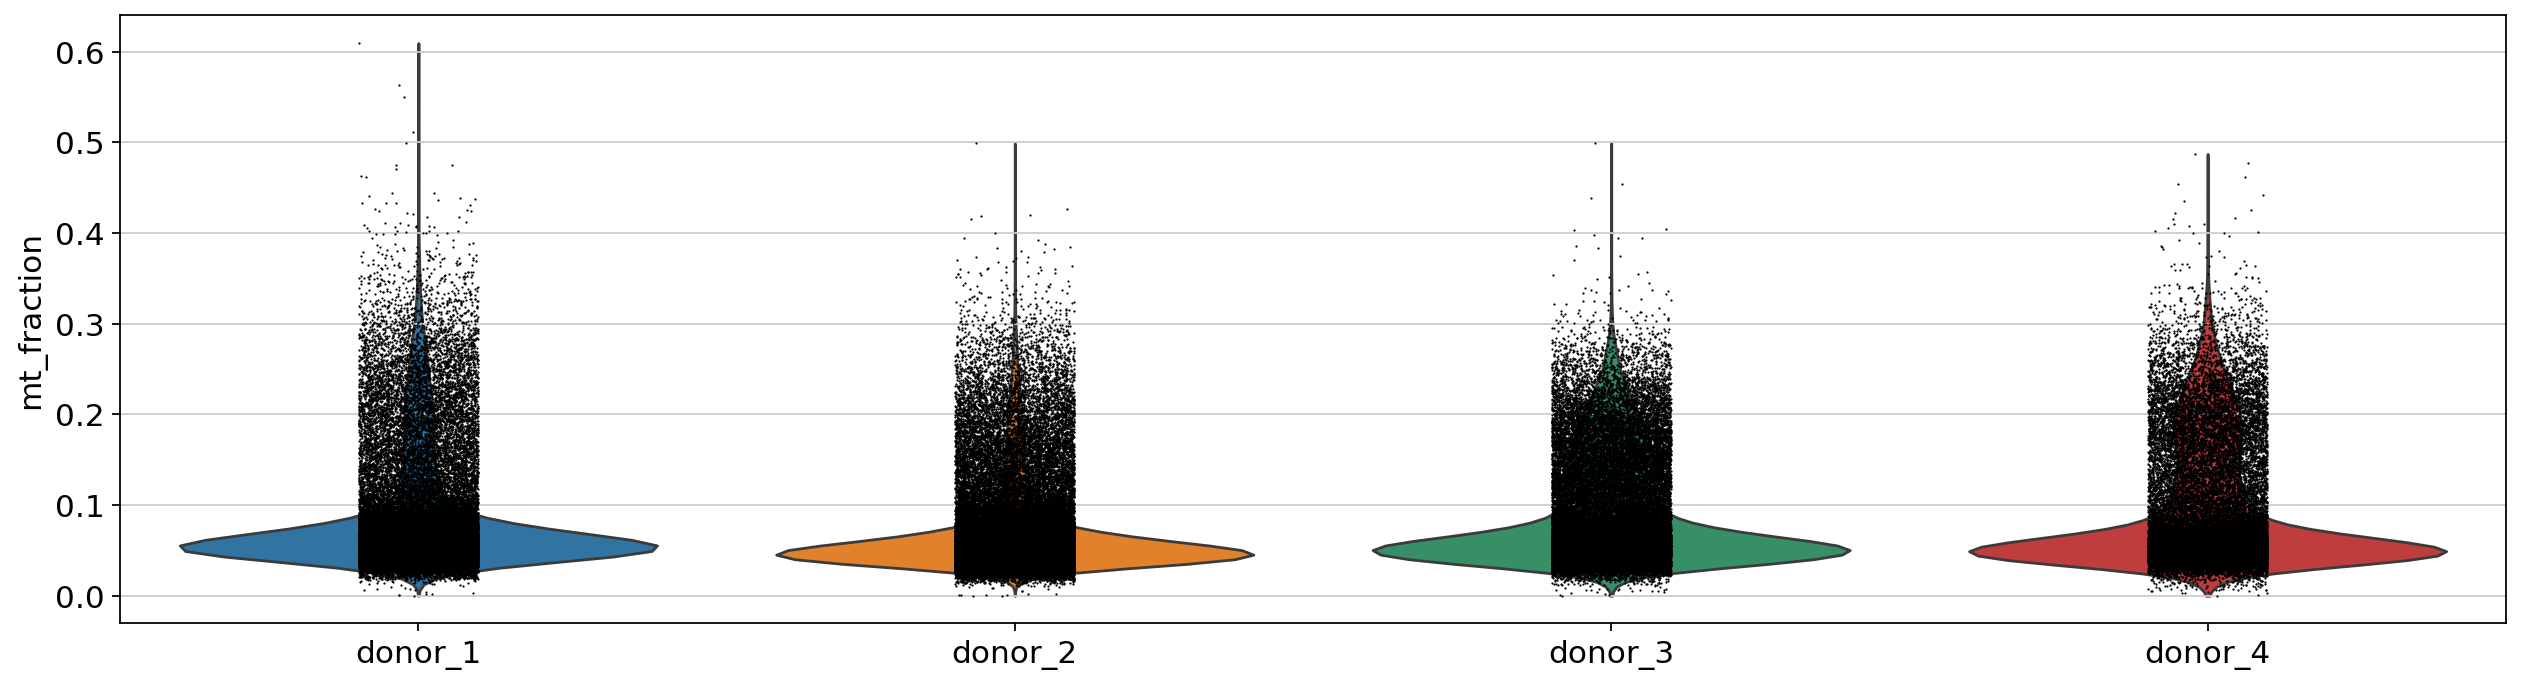

In [6]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (15, 5)
sc.pl.violin(adata, ['log_counts'], groupby='donor', size=1, log=False, rotation=0)
sc.pl.violin(adata, ['n_genes'], groupby='donor', size=1, log=False, rotation=0)
sc.pl.violin(adata, ['mt_fraction'], groupby='donor', size=1, log=False, rotation=0)

<Axes: title={'center': 'mt fraction'}, xlabel='n_counts', ylabel='n_genes'>

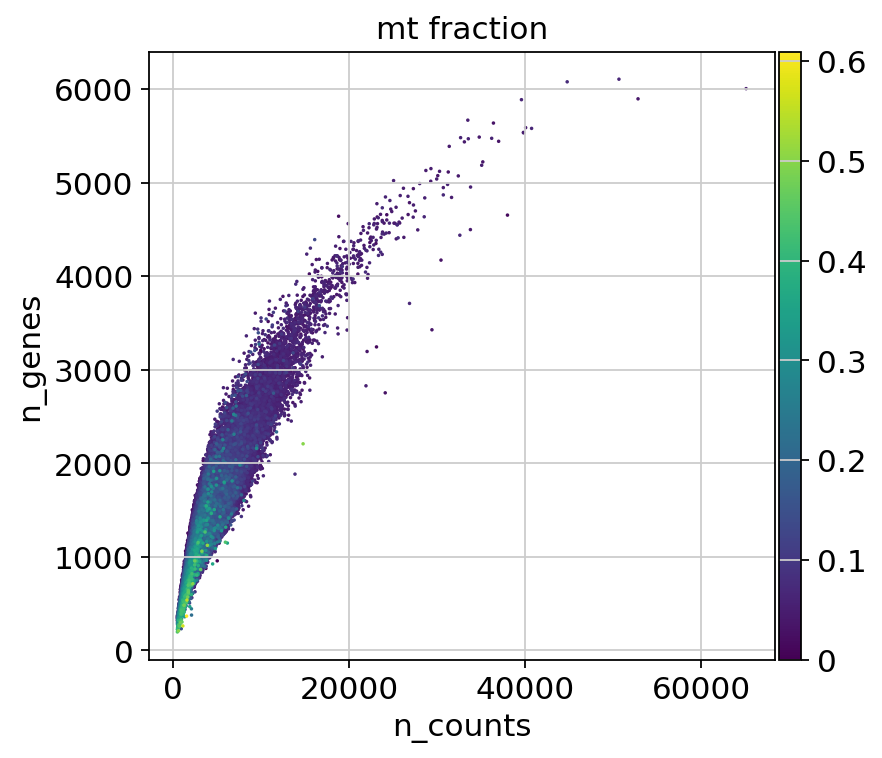

In [7]:
rcParams['figure.figsize'] = (5, 5)
sc.pl.scatter(adata, y='n_genes', x='n_counts', color='mt_fraction', size=10, show=False)

<Axes: title={'center': 'donor'}, xlabel='n_counts', ylabel='n_genes'>

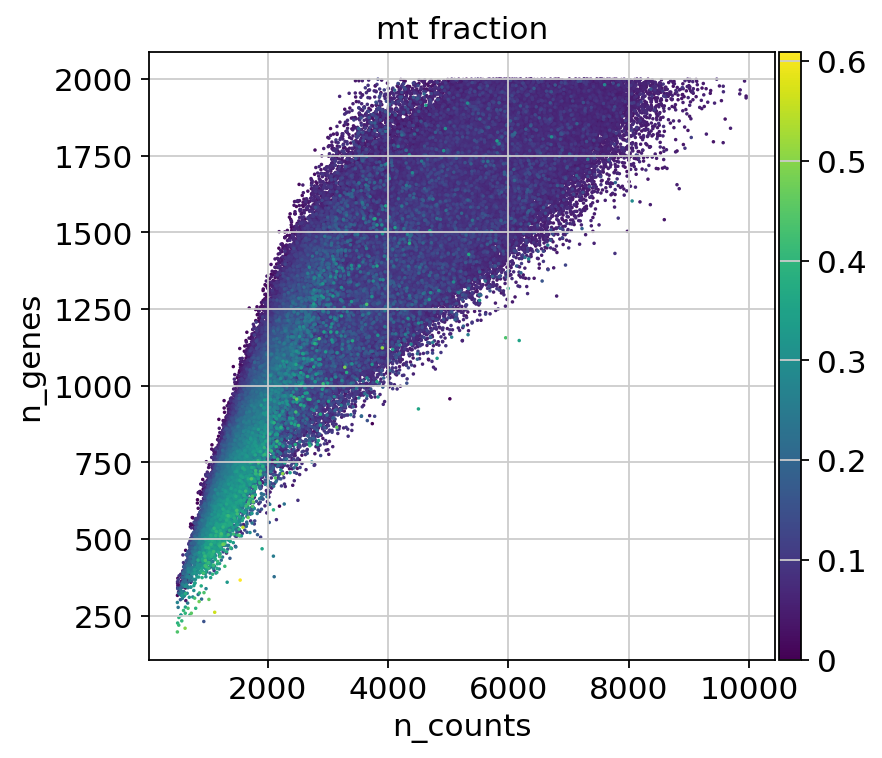

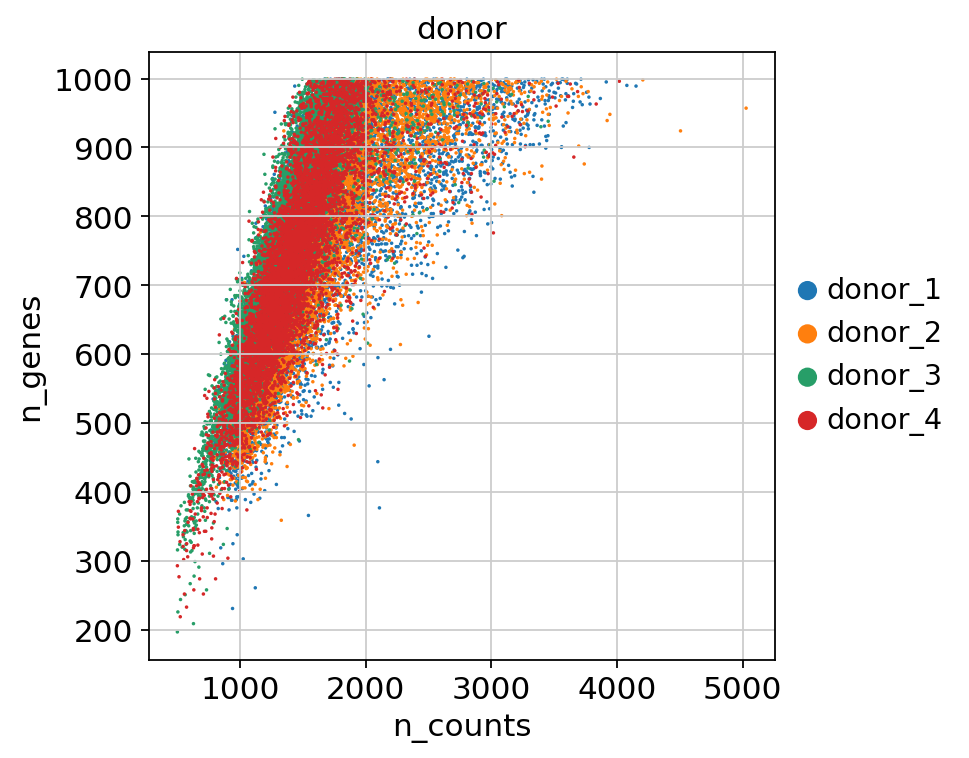

In [8]:
sc.pl.scatter(adata[np.logical_and(adata.obs['n_genes']<2000, adata.obs['n_counts']<10000)],
             y='n_genes', x='n_counts', color='mt_fraction', size=10, show=False)
sc.pl.scatter(adata[np.logical_and(adata.obs['n_genes']<1000, adata.obs['n_counts']<10000)],
             y='n_genes', x='n_counts', color='donor', size=10, show=False)

**Cell filtering**

In [9]:
adata_tmp = adata.copy()
print(f'Total number of cells: {adata_tmp.n_obs}')
high_mt = adata_tmp.obs['mt_fraction'] < 0.2
adata_tmp = adata_tmp[high_mt]
print(f'Number of cells after MT filter: {adata_tmp.n_obs}')

Total number of cells: 190425
Number of cells after MT filter: 177863


In [10]:
low_count = adata_tmp.obs['n_counts'] > 1000    # 或Scanpy 自带函数
adata_tmp = adata_tmp[low_count]
print(f'Number of cells after minimum count filter: {adata_tmp.n_obs}')
sc.pp.filter_cells(adata_tmp, max_counts=10000)
print(f'Number of cells after maximun filter: {adata_tmp.n_obs}')

Number of cells after minimum count filter: 176435
filtered out 2676 cells that have more than 10000 counts
Number of cells after maximun filter: 173759


In [11]:
low_genes = adata_tmp.obs['n_genes'] > 500
adata_tmp = adata_tmp[low_genes]
print(f'Number of cells after minimum gene filter: {adata_tmp.n_obs}')

Number of cells after minimum gene filter: 173698


**Gene filtering**

In [12]:
sc.pp.filter_genes(adata_tmp, min_cells=10)
print(f'Number of cells after gene filter: {adata_tmp.n_vars}')

filtered out 14268 genes that are detected in less than 10 cells
Number of cells after gene filter: 19270


**Doubletts detection, evaluated by Scrublet**

In [13]:
import scrublet as scr
import time
adata_tmp.obs['doublet_score'] = np.zeros(adata_tmp.shape[0])
adata_tmp.obs['doublet'] = np.zeros(adata_tmp.shape[0])

In [14]:
min_counts = 2
min_cells = 3
vscore_percentile = 85
n_pc = 50

expected_doublet_rate = 0.02
sim_doublet_ratio = 3
n_neighbors = 15

for batch in enumerate(adata_tmp.obs['donor'].cat.categories):
    print(batch)
    t0 = time.time()
    idx = np.flatnonzero(adata_tmp.obs['donor']==batch[1])
    scrub = scr.Scrublet(counts_matrix=adata_tmp[idx, :].X, 
                         n_neighbors=n_neighbors,
                         sim_doublet_ratio=sim_doublet_ratio,
                         expected_doublet_rate=expected_doublet_rate)
    doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=min_counts,
                                                              min_cells=min_cells,
                                                              n_prin_comps=n_pc,
                                                              use_approx_neighbors=True,
                                                              get_doublet_neighbor_parents=False)
    adata_tmp.obs['doublet_score'].iloc[idx] = doublet_scores
    adata_tmp.obs['doublet'].iloc[idx] = predicted_doublets
    t1 = time.time()
    print('Elapsed time: {:.1f} seconds'.format(t1-t0))

(0, 'donor_1')
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.14
Detected doublet rate = 2.0%
Estimated detectable doublet fraction = 47.8%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 4.1%
Elapsed time: 78.5 seconds
Elapsed time: 79.5 seconds
(1, 'donor_2')
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.14
Detected doublet rate = 2.4%
Estimated detectable doublet fraction = 38.2%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 6.4%
Elapsed time: 163.4 seconds
Elapsed time: 165.3 seconds
(2, 'donor_3')
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.14
Detected doublet rate = 1.8%
Estimated detectable doublet fraction = 43.2%
Overall doublet rate

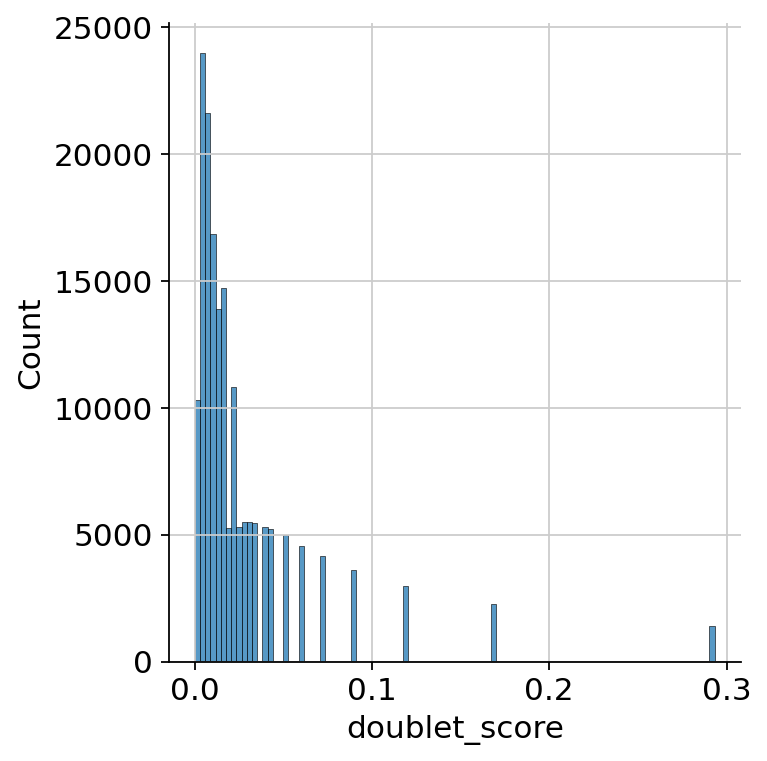

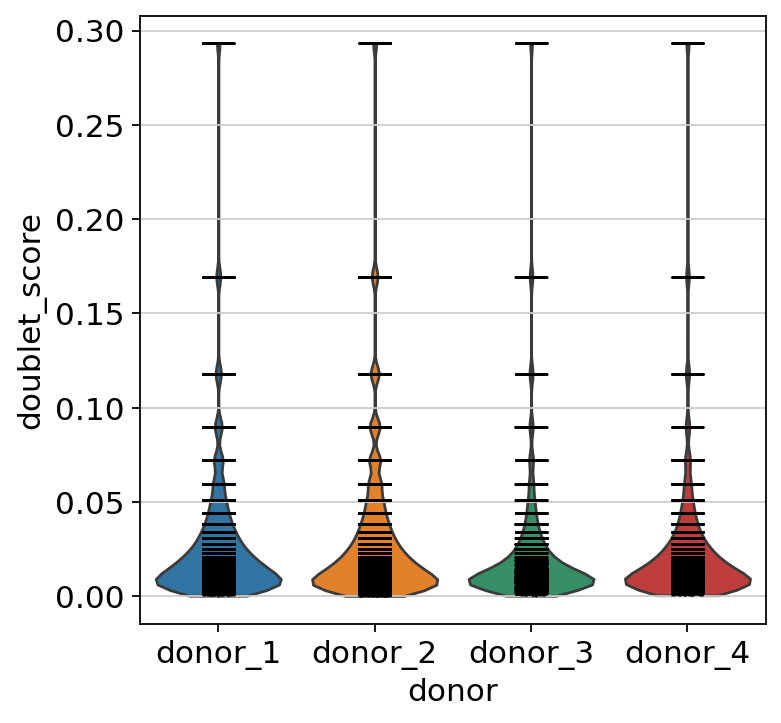

In [15]:
import seaborn as sb
sb.displot(adata_tmp.obs['doublet_score'], bins=100, kde=False)
sc.pl.violin(adata_tmp, ['doublet_score'], groupby='donor', size=1, log=False)

In [16]:
thr = 0.05
idx_filter = adata_tmp.obs['doublet_score'] <= thr
adata_tmp =  adata_tmp[idx_filter].copy()
print(f'Number of cells after doublet filter: {adata_tmp.n_obs}')

Number of cells after doublet filter: 149768


**After qc and filtering**

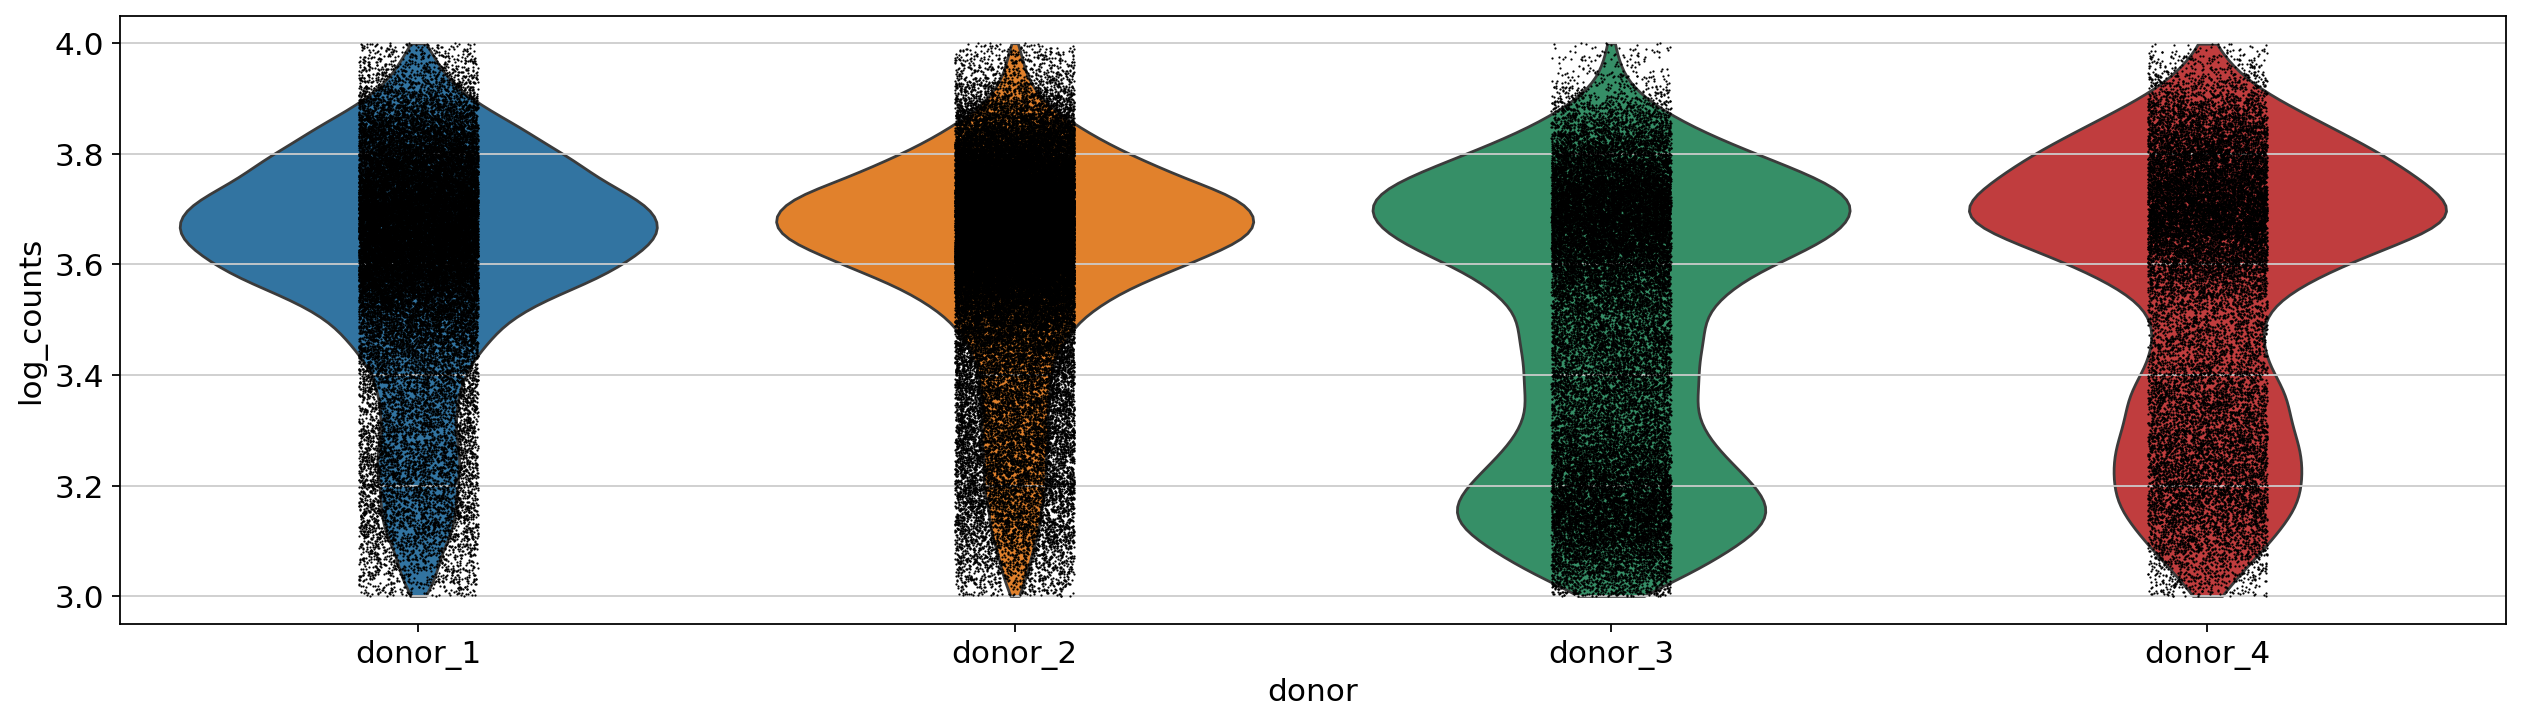

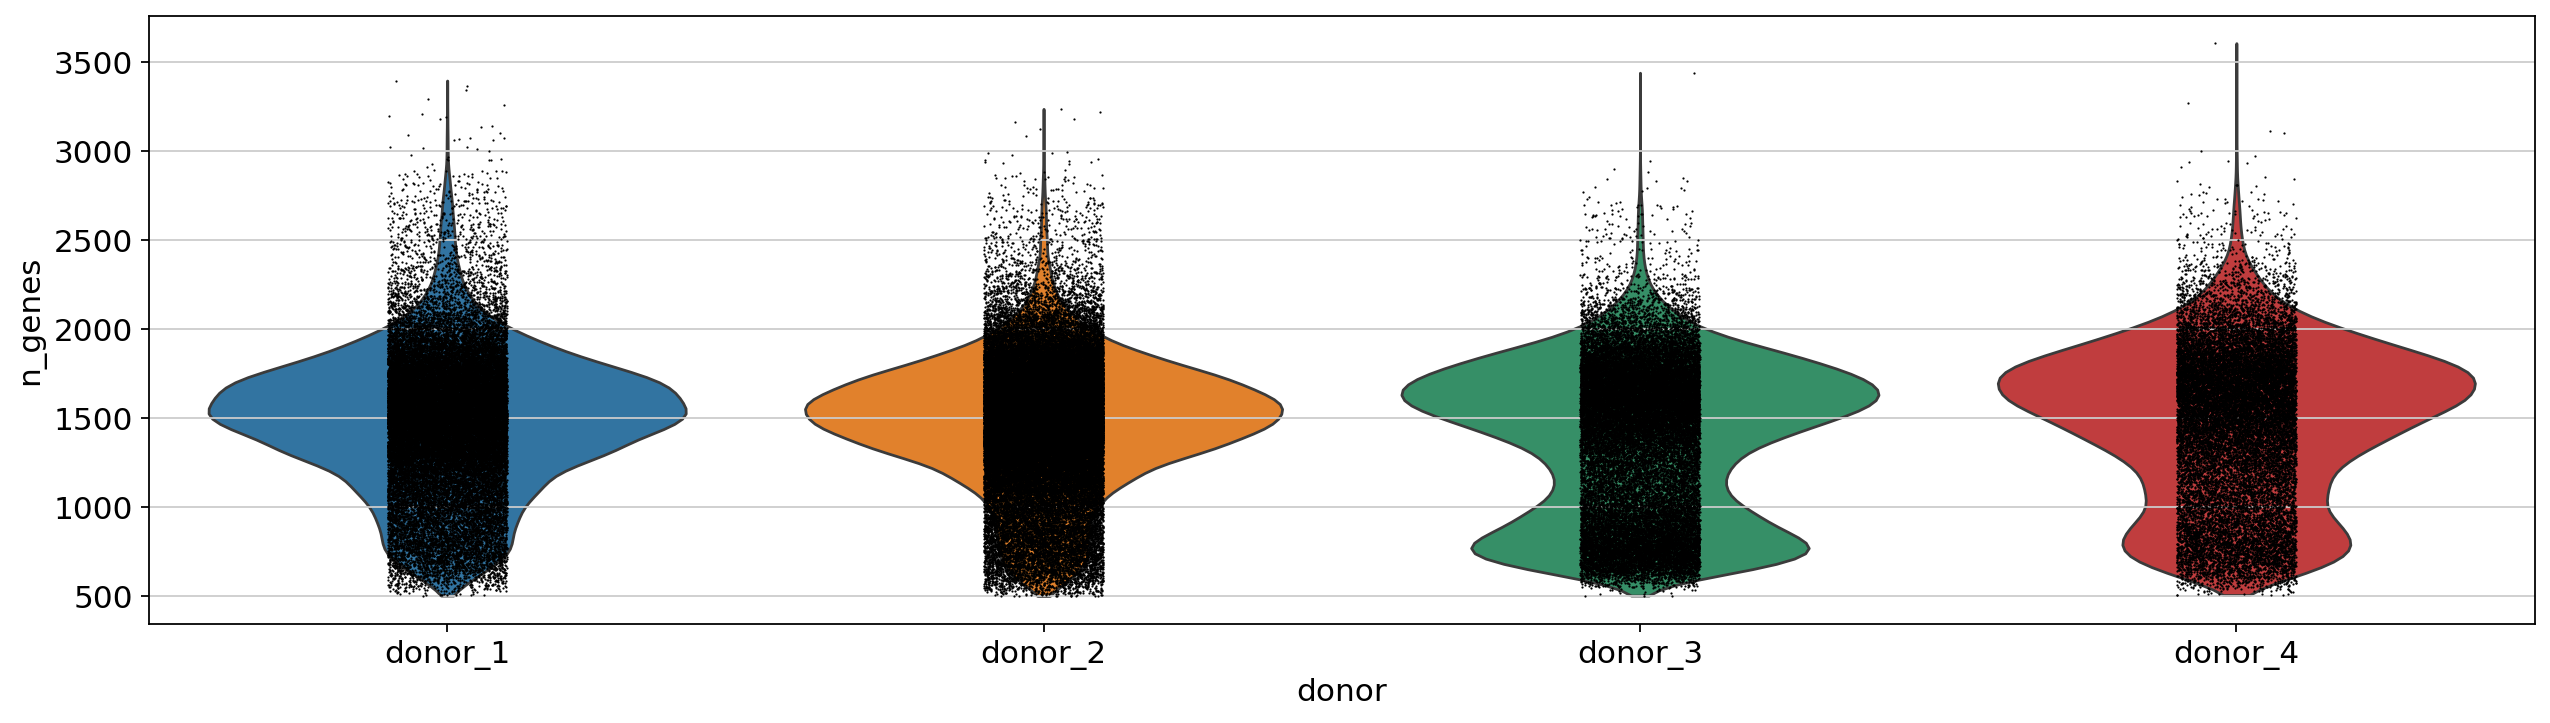

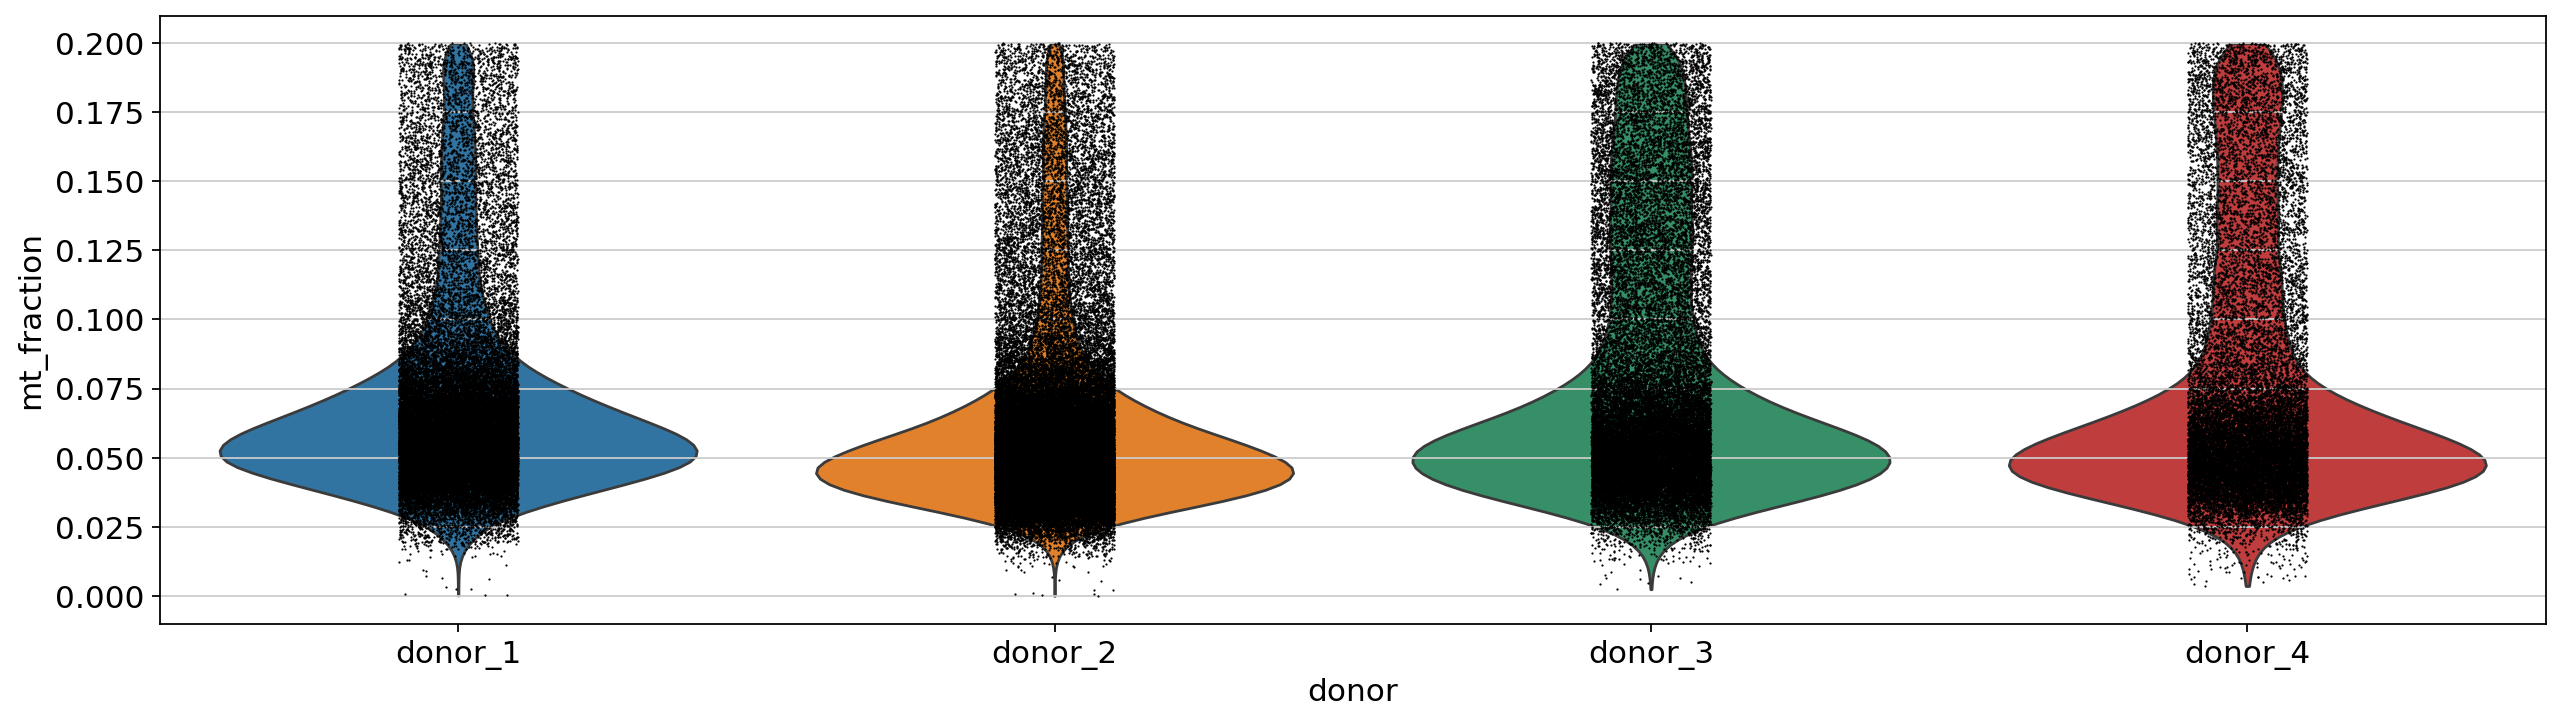

In [17]:
rcParams['figure.figsize'] = (15, 5)
sc.pl.violin(adata_tmp, ['log_counts'], groupby='donor', size=1, log=False)
sc.pl.violin(adata_tmp, ['n_genes'], groupby='donor', size=1, log=False)
sc.pl.violin(adata_tmp, ['mt_fraction'], groupby='donor', size=1, log=False)

In [18]:
df = adata_tmp.obs[['n_genes', 'n_counts', 'donor']]
df_all = pd.DataFrame(df.groupby(by='donor')['n_genes'].apply(np.mean).values,
                      index=df.groupby(by='donor')['n_genes'].apply(np.mean).index,
                      columns=['mean_genes'])
df_all['median_genes'] = df.groupby(by='donor')['n_genes'].apply(np.median).values
df_all['mean_counts'] = df.groupby(by='donor')['n_counts'].apply(np.mean).values
df_all['median_counts'] = df.groupby(by='donor')['n_counts'].apply(np.median).values
df_all

mean_genes  median_genes  mean_counts  median_counts
donor                                                         
donor_1  1475.809326        1505.0  4433.557617         4412.0
donor_2  1466.083314        1499.0  4409.296387         4488.0
donor_3  1372.292050        1467.0  3594.513428         3566.0
donor_4  1467.849410        1542.0  4185.132812         4395.0

In [19]:
adata_tmp.obs['doublet'] = adata_tmp.obs['doublet'].astype(str)
sc.write(adata=adata_tmp, filename=path_filtered)

**Normalization**

In [20]:
sc.pp.normalize_total(adata_tmp, target_sum=1e4)
sc.pp.log1p(adata_tmp)
sc.write(adata=adata_tmp, filename=path_logged)

normalizing counts per cell
    finished (0:00:00)


**Select HVGs**

In [21]:
adata_tmp.uns['log1p'] = {'base': None}
sc.pp.highly_variable_genes(adata_tmp, n_top_genes=5000, batch_key='donor') #, flavor='seurat_v3')
print(f'Shape before: {adata_tmp.shape}')
adata_tmp = adata_tmp[:, adata_tmp.var['highly_variable']]
print(f'Shape after: {adata_tmp.shape}')
sc.write(adata=adata_tmp, filename=path_hvg)

extracting highly variable genes
    finished (0:00:06)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Shape before: (149768, 19270)
Shape after: (149768, 5000)


**Prepare for vqTCR input style**
- apply index_chains to get `obsm.chain_indices` and apply chain_qc to get `obs.chain_pairing` using scirpy
- Filter cells with single pair IRs (clean orphans and more than one pair chains)

In [22]:
adata = sc.read_h5ad(path_hvg)
ir.pp.index_chains(adata)
ir.tl.chain_qc(adata)
junction_aa = ir.get.airr(adata, "junction_aa")
print(adata.shape)
adata = adata[adata.obs.chain_pairing.isin(['single pair'])]
print(adata.shape)

Filtering chains...
Indexing VJ chains...
Indexing VDJ chains...
build result array
Stored result in `adata.obs["receptor_type"]`.
Stored result in `adata.obs["receptor_subtype"]`.
Stored result in `adata.obs["chain_pairing"]`.
(149768, 5000)
(112526, 5000)


**Clonotype annotation**

In [23]:
ir.pp.ir_dist(adata)
ir.tl.define_clonotypes(adata, 
                        key_added='clonotype', 
                        receptor_arms='all', 
                        dual_ir='primary_only')

Computing sequence x sequence distance matrix for VJ sequences.
Computing sequence x sequence distance matrix for VDJ sequences.
Initializing lookup tables. 
--> Done initializing lookup tables. (0:00:03)
Computing clonotype x clonotype distances.
--> Done computing clonotype x clonotype distances.  (0:00:00)
Stored result in `adata.obs["clonotype"]`.
Stored result in `adata.obs["clonotype_size"]`.


if IR has more than single pair recepters, use 'VJ_1_junction_aa' and 'VDJ_1_junction_aa' in adata.obs

In [24]:
adata.obs.chain_pairing.value_counts()

chain_pairing
single pair    112526
Name: count, dtype: int64

In [25]:
adata.obs.clonotype.value_counts()

clonotype
16004    5255
35809    3782
1116     3735
25225    2903
7        2170
         ... 
14590       1
14591       1
14592       1
14593       1
14583       1
Name: count, Length: 44398, dtype: int64

**TCR tokenizer**

using ESM vocab to tokenize the amino acid sequences of TCR

In [26]:
junction_aa = ir.get.airr(adata, 'junction_aa')
junction_aa

VJ_1_junction_aa  VDJ_1_junction_aa  \
AAACGGGAGAAGATTC-1-donor_1       CAMREGSNDMRF    CASSIKGPFRTEAFF   
AAACGGGTCGGACAAG-1-donor_1     CAREHMDSNYQLIW    CASSQLGRGDNEQFF   
AAAGTAGAGACGCTTT-1-donor_1      CAVIVWGNNRLAF  CASSLDRRLAGQETQYF   
AAAGTAGAGTTACGGG-1-donor_1     CAESMDNYGQNFVF     CASSLSVTTDTQYF   
AACCGCGGTCTGCGGT-1-donor_1   CAEIPNYGGSQGNLIF  CASSNTLAGVPLNEQFF   
...                                       ...                ...   
TTTGTCACATCAGTAC-8-donor_4     CIPPAQGGSEKLVF   CASSETTGTFNYEQFF   
TTTGTCAGTCTAAACC-8-donor_4    CAMRGLEGGGNKLTF    CASSQDRGFGETQYF   
TTTGTCAGTCTCTCGT-8-donor_4  CILRDGKGGGSQGNLIF      CASSSREPRELFF   
TTTGTCATCCCACTTG-8-donor_4   CAVRDLMDTGRRALTF        CSATGQETQYF   
TTTGTCATCTCTAAGG-8-donor_4    CGAIPTQGGSEKLVF     CATSGTENTGELFF   

                           VJ_2_junction_aa VDJ_2_junction_aa  
AAACGGGAGAAGATTC-1-donor_1             None              None  
AAACGGGTCGGACAAG-1-donor_1             None              None  
AAAGTAGAGACGCTTT-1-donor_1             None              None  
AAAGTAGAGTTACGGG-1-donor_1             None              None  
AACCGCGGTCTGCGGT-1-donor_1             None              None  
...                                     ...               ...  
TTTGTCACATCAGTAC-8-donor_4             None              None  
TTTGTCAGTCTAAACC-8-donor_4             None              None  
TTTGTCAGTCTCTCGT-8-donor_4             None              None  
TTTGTCATCCCACTTG-8-donor_4             None              None  
TTTGTCATCTCTAAGG-8-donor_4             None              None  

[112526 rows x 4 columns]

In [27]:
adata.obs['VJ_1_junction_aa'] = junction_aa['VJ_1_junction_aa']
adata.obs['VDJ_1_junction_aa'] = junction_aa['VDJ_1_junction_aa']
len_alpha = junction_aa.VJ_1_junction_aa.str.len().max()
len_beta = junction_aa.VDJ_1_junction_aa.str.len().max()
pad_len = max(len_alpha, len_beta)
pad_len

np.int64(26)

In [28]:
aa_to_id = vq.TCR_VOCAB
adata.obs['alpha_len'] = junction_aa.VJ_1_junction_aa.str.len().values
adata.obs['beta_len'] = junction_aa.VDJ_1_junction_aa.str.len().values

In [29]:
vq.aa_tokenizer(adata, 
                esm_type='facebook/esm2_t6_8M_UR50D',
                read_col='VJ_1_junction_aa',
                label_col='alpha_seq',
                length_col='alpha_len', 
                mask_col='alpha_mask', 
                pad=pad_len, 
                add_special_tokens=False)

In [30]:
vq.aa_tokenizer(adata, 
                esm_type='facebook/esm2_t6_8M_UR50D',
                read_col='VDJ_1_junction_aa',
                label_col='beta_seq',
                length_col='beta_len', 
                mask_col='beta_mask', 
                pad=pad_len, 
                add_special_tokens=False)
adata

AnnData object with n_obs × n_vars = 112526 × 5000
    obs: 'barcode', 'donor', 'cell_clono_cdr3_aa', 'cell_clono_cdr3_nt', 'CD3', 'CD19', 'CD45RA', 'CD4', 'CD8a', 'CD14', 'CD45RO', 'CD279_PD-1', 'IgG1', 'IgG2a', 'IgG2b', 'CD127', 'CD197_CCR7', 'HLA-DR', 'A0101_VTEHDTLLY_IE-1_CMV', 'A0201_KTWGQYWQV_gp100_Cancer', 'A0201_ELAGIGILTV_MART-1_Cancer', 'A0201_CLLWSFQTSA_Tyrosinase_Cancer', 'A0201_IMDQVPFSV_gp100_Cancer', 'A0201_SLLMWITQV_NY-ESO-1_Cancer', 'A0201_KVAELVHFL_MAGE-A3_Cancer', 'A0201_KVLEYVIKV_MAGE-A1_Cancer', 'A0201_CLLGTYTQDV_Kanamycin-B-dioxygenase', 'A0201_LLDFVRFMGV_EBNA-3B_EBV', 'A0201_LLMGTLGIVC_HPV-16E7_82-91', 'A0201_CLGGLLTMV_LMP-2A_EBV', 'A0201_YLLEMLWRL_LMP1_EBV', 'A0201_FLYALALLL_LMP2A_EBV', 'A0201_GILGFVFTL_Flu-MP_Influenza', 'A0201_GLCTLVAML_BMLF1_EBV', 'A0201_NLVPMVATV_pp65_CMV', 'A0201_ILKEPVHGV_RT_HIV', 'A0201_FLASKIGRLV_Ca2-indepen-Plip-A2', 'A2402_CYTWNQMNL_WT1-(235-243)236M_Y', 'A0201_RTLNAWVKV_Gag-protein_HIV', 'A0201_KLQCVDLHV_PSA146-154', 'A0201_LLFGYPVYV_

In [31]:
adata.write_h5ad(path_token, compression='gzip')

**Antigen binding data**

In [32]:
antigen_binding_list = [x for x in adata.obs.columns if x.endswith('_binder')]
binding_matrix = (adata.obs[antigen_binding_list] == 'True').values.astype(int)
print('shape of binding_matrix: ', binding_matrix.shape)
print('T cells with binding: ', binding_matrix.sum(axis=1)[:100])
unique_value, count = np.unique(binding_matrix.sum(axis=1), return_counts=True)
for unique_value_, count_ in zip(unique_value, count):
    print(f'Cells with {unique_value_} bindings: {count_}')

shape of binding_matrix:  (112526, 50)
T cells with binding:  [1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 1 1 0 1 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 0]
Cells with 0 bindings: 58094
Cells with 1 bindings: 54432


In [33]:
label_to_binding = {label_id: antigen for label_id, antigen in enumerate(antigen_binding_list)}
label_to_binding[-1] = 'no_data'  # For cells without binding data
binding_to_label = {antigen: label_id for label_id, antigen in enumerate(antigen_binding_list)}
binding_to_label['no_data'] = -1
# sanity check, if both dicts are the reverse of each other
binding_to_label == {v: k for k, v in label_to_binding.items()}

True

In [34]:
# has binding
adata.obs['has_binding'] = binding_matrix.sum(axis=1).astype(bool)
adata.obs['has_binding'].head()

AAACGGGAGAAGATTC-1-donor_1     True
AAACGGGTCGGACAAG-1-donor_1    False
AAAGTAGAGACGCTTT-1-donor_1    False
AAAGTAGAGTTACGGG-1-donor_1    False
AACCGCGGTCTGCGGT-1-donor_1    False
Name: has_binding, dtype: bool

In [35]:
# binding label
adata.obs['binding_label'] = np.argmax(binding_matrix, axis=1)
adata.obs['binding_label'][~adata.obs['has_binding']] = -1
adata.obs['binding_label'].head()

AAACGGGAGAAGATTC-1-donor_1    29
AAACGGGTCGGACAAG-1-donor_1    -1
AAAGTAGAGACGCTTT-1-donor_1    -1
AAAGTAGAGTTACGGG-1-donor_1    -1
AACCGCGGTCTGCGGT-1-donor_1    -1
Name: binding_label, dtype: int64

In [36]:
# binding name
adata.obs['binding_name'] = adata.obs['binding_label'].map(label_to_binding)
adata.obs['binding_name'].head()

AAACGGGAGAAGATTC-1-donor_1    A0301_KLGGALQAK_IE-1_CMV_binder
AAACGGGTCGGACAAG-1-donor_1                            no_data
AAAGTAGAGACGCTTT-1-donor_1                            no_data
AAAGTAGAGTTACGGG-1-donor_1                            no_data
AACCGCGGTCTGCGGT-1-donor_1                            no_data
Name: binding_name, dtype: object

**Split the data into train and test sets** 

In [37]:
adata.obs['donor+binding'] = adata.obs['donor'].astype(str) + '_' + adata.obs['binding_name'].astype(str)
adata.obs['donor+binding'].sample(10)

GGTATTGAGATCGGGT-6-donor_3     donor_3_A0301_KLGGALQAK_IE-1_CMV_binder
GTCGGGTCAAGTAGTA-36-donor_1                            donor_1_no_data
TAAACCGGTCATATCG-9-donor_2                             donor_2_no_data
CATTATCAGGCCGAAT-19-donor_1                            donor_1_no_data
GACTGCGCACAAGCCC-5-donor_3     donor_3_A0301_KLGGALQAK_IE-1_CMV_binder
TTGACTTTCGTATCAG-3-donor_2     donor_2_B0801_RAKFKQLL_BZLF1_EBV_binder
GACCTGGAGCAGACTG-4-donor_4                             donor_4_no_data
TGGCCAGTCTTGCCGT-40-donor_2    donor_2_A0301_KLGGALQAK_IE-1_CMV_binder
CAGATCAAGTACGATA-17-donor_2    donor_2_B0801_RAKFKQLL_BZLF1_EBV_binder
ACAGCTAGTTCTGTTT-24-donor_2    donor_2_A0301_KLGGALQAK_IE-1_CMV_binder
Name: donor+binding, dtype: object

In [38]:
random_seed = 42
# create Train-Val and Test set
train_val, test = vq.stratified_group_shuffle_split(adata.obs, stratify_col='donor+binding', 
                                                    group_col='clonotype', val_split=0.20, 
                                                    random_seed=random_seed)
# split Train-Val into Train and Val set
train, val = vq.stratified_group_shuffle_split(train_val, stratify_col='donor+binding', 
                                               group_col='clonotype', val_split=0.25, 
                                               random_seed=random_seed)

  0%|          | 0/107 [00:00<?, ?it/s]

100%|██████████| 105/105 [00:00<00:00, 126.55it/s]


In [39]:
print('Train Samples: ', len(train))
print('Train Ratio: ', len(train) / len(adata.obs))
print('Val Samples: ', len(val))
print('Val Ratio: ', len(val) / len(adata.obs))
print('Test Samples: ', len(test))
print('Test Ratio: ', len(test) / len(adata.obs))

Train Samples:  69447
Train Ratio:  0.6171640332012157
Val Samples:  23752
Val Ratio:  0.2110801059310737
Test Samples:  19327
Test Ratio:  0.17175586086771058


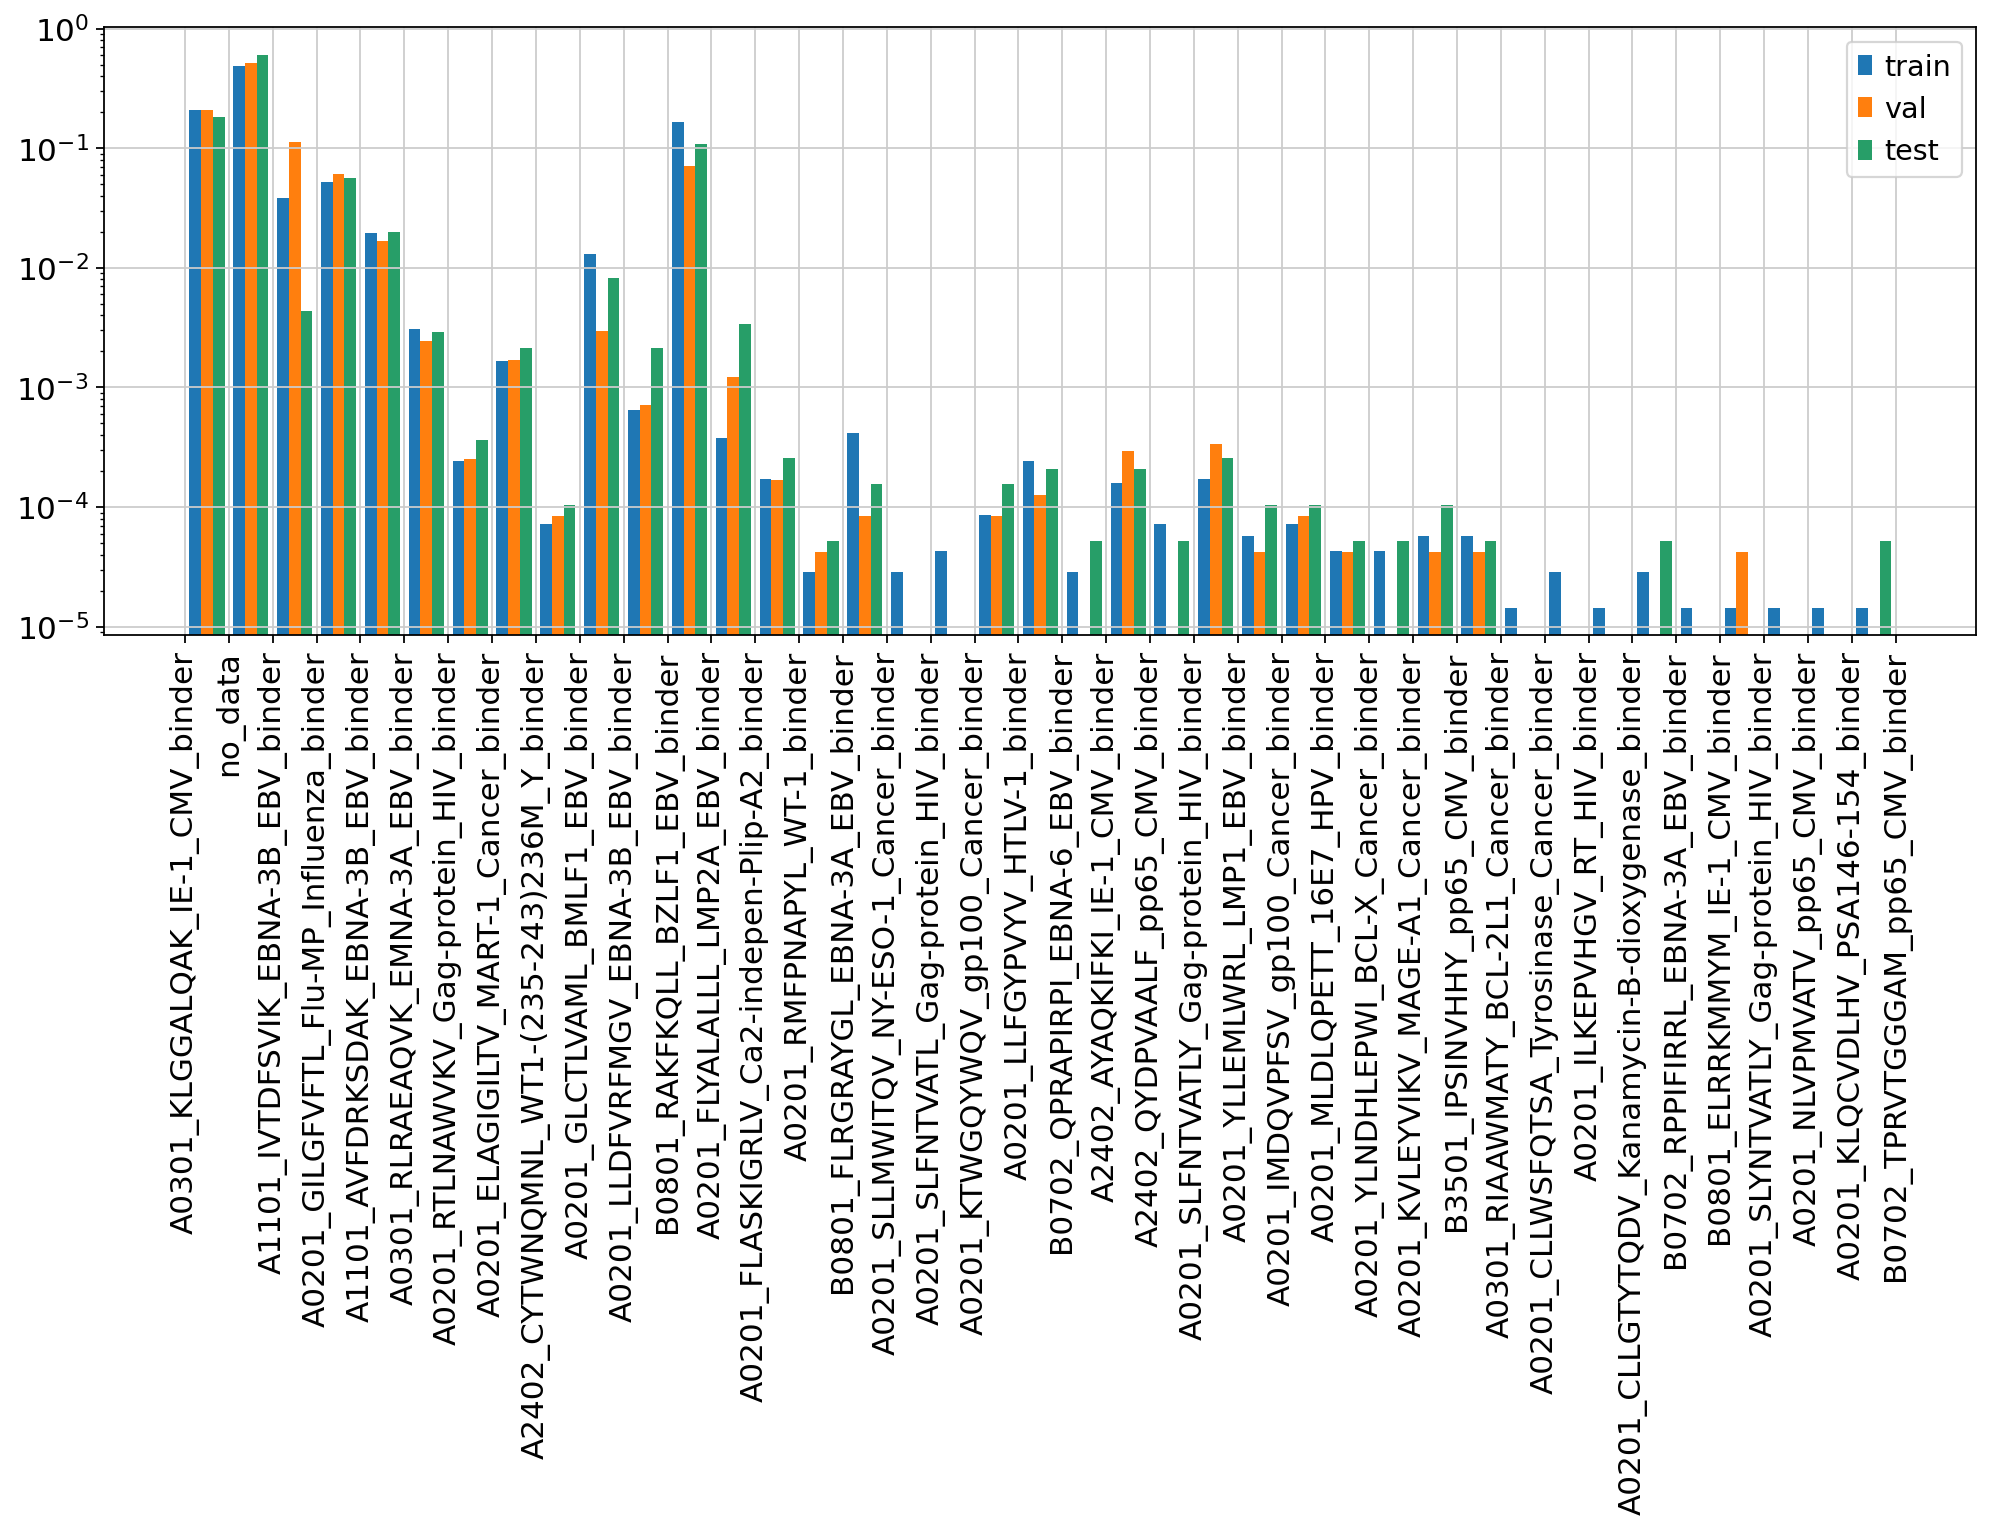

In [40]:
import matplotlib.pyplot as pl
pl.figure(figsize=(15,5))
pl.hist([train['binding_name'], val['binding_name'], test['binding_name']], 
        density=True, bins=len(train['binding_name'].unique()), 
        label=['train', 'val', 'test'])
pl.yscale('log')
pl.xticks(rotation='vertical')
pl.legend(loc='upper right')
pl.show()

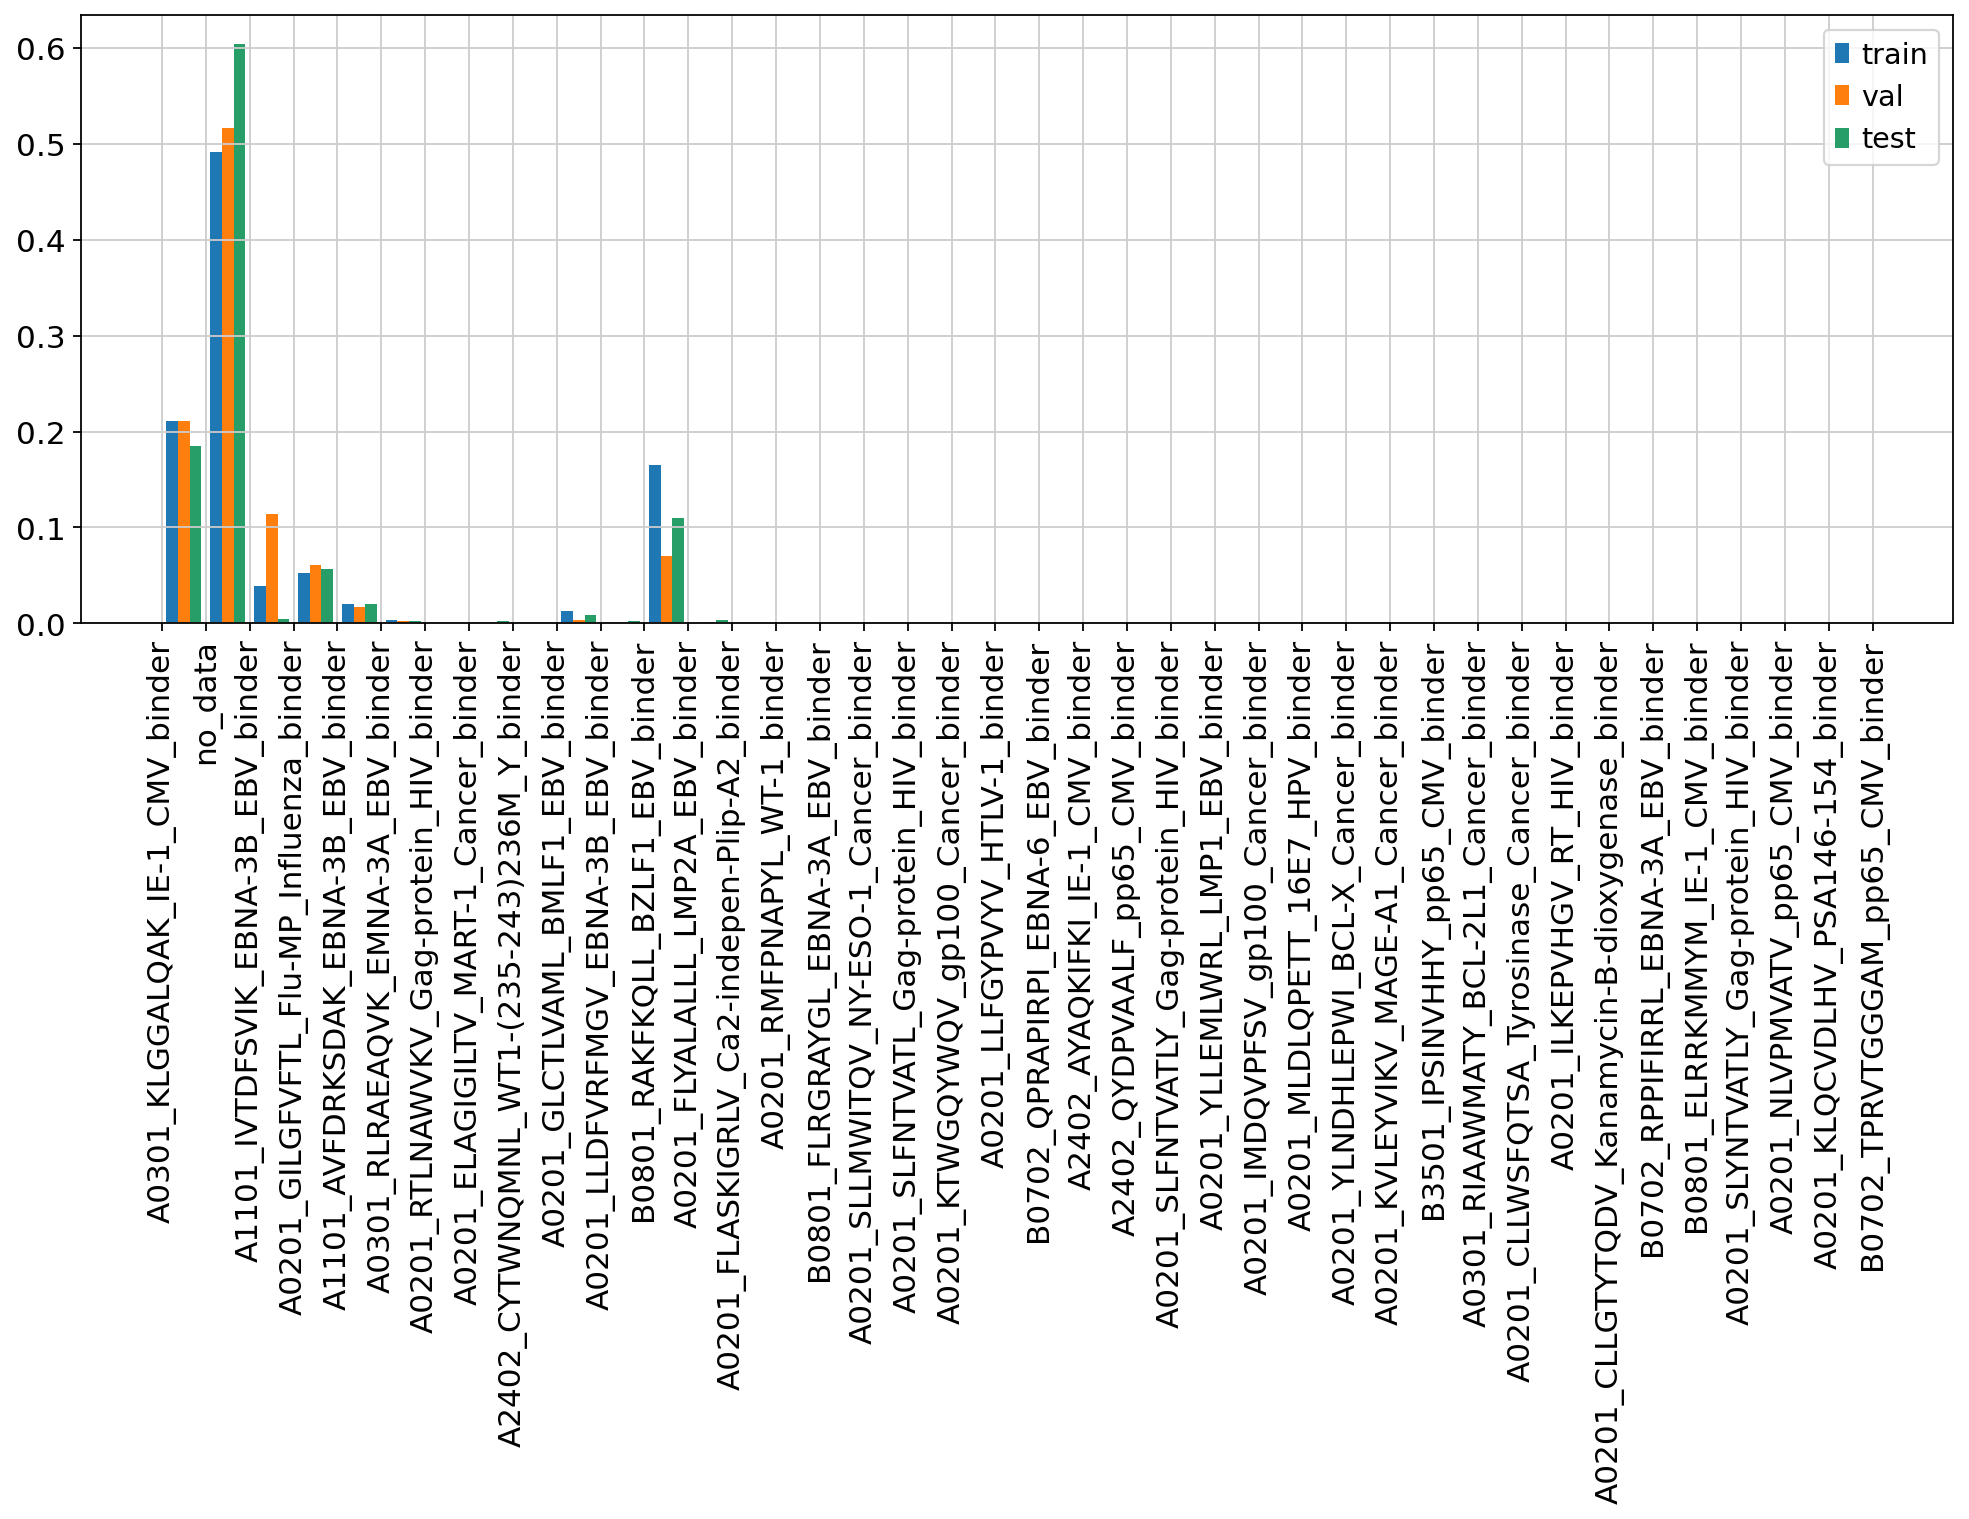

In [41]:
pl.figure(figsize=(15,5))
pl.hist([train['binding_name'], val['binding_name'], test['binding_name']], 
        density=True, bins=len(train['binding_name'].unique()), 
        label=['train', 'val', 'test'])
pl.xticks(rotation='vertical')
pl.legend(loc='upper right')
pl.show()

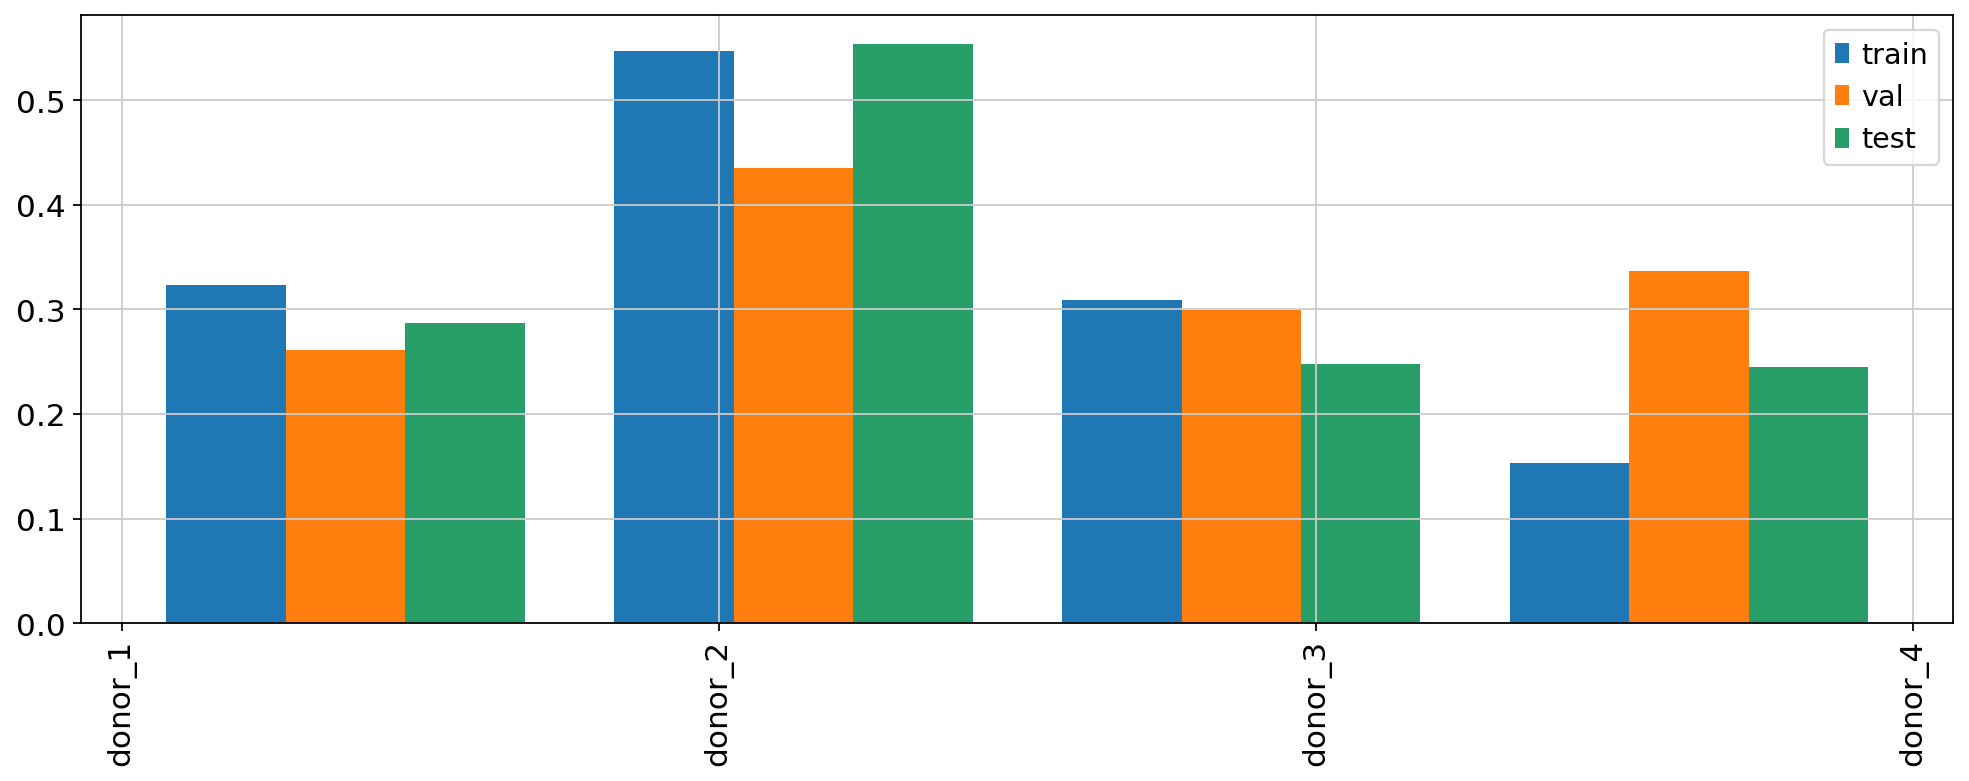

In [42]:
pl.figure(figsize=(15,5))
pl.hist([train['donor'], val['donor'], test['donor']], 
        density=True, bins=len(train['donor'].unique()), 
        label=['train', 'val', 'test'])
pl.xticks(rotation='vertical')
pl.legend(loc='upper right')
pl.show()

In [43]:
# check if clonotypes are unique within each set
form_train = set(train['clonotype'].tolist())
form_val = set(val['clonotype'].tolist())
form_test = set(test['clonotype'].tolist())

print('Intersection in clonotypes between two sets should be empty set().')
print('Intersection in clonotypes between train and test: ', form_train.intersection(form_test))
print('Intersection in clonotypes between train and val: ', form_train.intersection(form_val))
print('Intersection in clonotypes between val and test: ', form_val.intersection(form_test))

Intersection in clonotypes between two sets should be empty set().
Intersection in clonotypes between train and test:  set()
Intersection in clonotypes between train and val:  set()
Intersection in clonotypes between val and test:  set()


In [44]:
adata.obs.loc[train.index, 'set'] = 'train'
adata.obs.loc[val.index, 'set'] = 'val'
adata.obs.loc[test.index, 'set'] = 'test'
adata.obs['set'].value_counts()
adata.obs['set'].sample(20)
adata.write_h5ad(path_clean_split, compression='gzip')

**Add major pMHC prediction labels**

In [45]:
# add prediction labels to adata
adata.obs[['binding_name', 'binding_label']]
high_count_antigens= vq.HIGH_COUNT_ANTIGENS.copy()
print('high count antigens: ', high_count_antigens)

high count antigens:  ['A0201_ELAGIGILTV_MART-1_Cancer_binder', 'A0201_GILGFVFTL_Flu-MP_Influenza_binder', 'A0201_GLCTLVAML_BMLF1_EBV_binder', 'A0301_KLGGALQAK_IE-1_CMV_binder', 'A0301_RLRAEAQVK_EMNA-3A_EBV_binder', 'A1101_IVTDFSVIK_EBNA-3B_EBV_binder', 'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder', 'B0801_RAKFKQLL_BZLF1_EBV_binder']


In [46]:
adata.obs['high_count_binding_name'] = adata.obs['binding_name']
# set rare antigen specificities to 'no_data'
adata.obs['high_count_binding_name'][~adata.obs['high_count_binding_name'].isin(high_count_antigens)] = 'no_data'
adata.obs['high_count_binding_name'] = adata.obs['high_count_binding_name'].astype(str)
adata.obs['high_count_binding_name'].unique()

array(['A0301_KLGGALQAK_IE-1_CMV_binder', 'no_data',
       'A1101_IVTDFSVIK_EBNA-3B_EBV_binder',
       'B0801_RAKFKQLL_BZLF1_EBV_binder',
       'A0201_GILGFVFTL_Flu-MP_Influenza_binder',
       'A0301_RLRAEAQVK_EMNA-3A_EBV_binder',
       'A0201_ELAGIGILTV_MART-1_Cancer_binder',
       'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder',
       'A0201_GLCTLVAML_BMLF1_EBV_binder'], dtype=object)

In [47]:
# use this high_count_antigens list to be consistent with the order (alphabetical)
high_count_antigens += ['no_data']
specificity_to_label = {k: v for v, k in enumerate(high_count_antigens)}
label_to_specificity = {k: v for k, v in enumerate(high_count_antigens)}
adata.uns['specificity_to_label'] = specificity_to_label
# adata.uns['label_to_specificity'] = label_to_specificity
print('sepcificity_to_label: ', specificity_to_label)

sepcificity_to_label:  {'A0201_ELAGIGILTV_MART-1_Cancer_binder': 0, 'A0201_GILGFVFTL_Flu-MP_Influenza_binder': 1, 'A0201_GLCTLVAML_BMLF1_EBV_binder': 2, 'A0301_KLGGALQAK_IE-1_CMV_binder': 3, 'A0301_RLRAEAQVK_EMNA-3A_EBV_binder': 4, 'A1101_IVTDFSVIK_EBNA-3B_EBV_binder': 5, 'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder': 6, 'B0801_RAKFKQLL_BZLF1_EBV_binder': 7, 'no_data': 8}


In [48]:
adata.obs['high_count_binding_label'] = adata.obs['high_count_binding_name'].map(specificity_to_label)
adata.obs['high_count_binding_label'].value_counts()

high_count_binding_label
8    58563
3    23232
7    15271
1     6163
5     5479
6     2148
2     1143
4      330
0      197
Name: count, dtype: int64

In [54]:
adata.write_h5ad(path_supervised, compression='gzip')

**Add binding avidity information**

In [50]:
cols_binder_counts = vq.HIGH_COUNT_ANTIGENS
cols_binder_counts = ['_'.join(el.split('_')[:-1]) for el in cols_binder_counts]
binding_counts = []
for donor in range(1, 5):
    path_binding = path_base + f'/donor{donor}/vdj_v1_hs_aggregated_donor{donor}_binarized_matrix.csv'
    binarized_matrix = pd.read_csv(path_binding, sep=',', header=0, index_col=0)
    binarized_matrix.index.name = None
    binarized_matrix = binarized_matrix[cols_binder_counts]
    binarized_matrix.index = binarized_matrix.index + f'-donor_{donor}'
    binding_counts.append(binarized_matrix)
binding_counts = pd.concat(binding_counts)
binding_counts

A0201_ELAGIGILTV_MART-1_Cancer  \
AAACCTGAGACAAAGG-4-donor_1                              0.0   
AAACCTGAGACTGTAA-34-donor_1                             0.0   
AAACCTGAGAGCCCAA-5-donor_1                              0.0   
AAACCTGAGAGCTGCA-24-donor_1                             0.0   
AAACCTGAGAGGGATA-8-donor_1                              0.0   
...                                                     ...   
TTTGTCATCGTTTGCC-4-donor_4                              0.0   
TTTGTCATCTACCAGA-1-donor_4                              0.0   
TTTGTCATCTCTAAGG-8-donor_4                              0.0   
TTTGTCATCTGCAAGT-4-donor_4                              0.0   
TTTGTCATCTTAGAGC-2-donor_4                              0.0   

                             A0201_GILGFVFTL_Flu-MP_Influenza  \
AAACCTGAGACAAAGG-4-donor_1                                0.0   
AAACCTGAGACTGTAA-34-donor_1                               0.0   
AAACCTGAGAGCCCAA-5-donor_1                                0.0   
AAACCTGAGAGCTGCA-24-donor_1                               1.0   
AAACCTGAGAGGGATA-8-donor_1                                0.0   
...                                                       ...   
TTTGTCATCGTTTGCC-4-donor_4                                0.0   
TTTGTCATCTACCAGA-1-donor_4                                0.0   
TTTGTCATCTCTAAGG-8-donor_4                                0.0   
TTTGTCATCTGCAAGT-4-donor_4                                0.0   
TTTGTCATCTTAGAGC-2-donor_4                                0.0   

                             A0201_GLCTLVAML_BMLF1_EBV  \
AAACCTGAGACAAAGG-4-donor_1                         0.0   
AAACCTGAGACTGTAA-34-donor_1                        0.0   
AAACCTGAGAGCCCAA-5-donor_1                         0.0   
AAACCTGAGAGCTGCA-24-donor_1                        0.0   
AAACCTGAGAGGGATA-8-donor_1                         0.0   
...                                                ...   
TTTGTCATCGTTTGCC-4-donor_4                         0.0   
TTTGTCATCTACCAGA-1-donor_4                         0.0   
TTTGTCATCTCTAAGG-8-donor_4                         0.0   
TTTGTCATCTGCAAGT-4-donor_4                         0.0   
TTTGTCATCTTAGAGC-2-donor_4                         0.0   

                             A0301_KLGGALQAK_IE-1_CMV  \
AAACCTGAGACAAAGG-4-donor_1                        0.0   
AAACCTGAGACTGTAA-34-donor_1                       4.0   
AAACCTGAGAGCCCAA-5-donor_1                        0.0   
AAACCTGAGAGCTGCA-24-donor_1                       1.0   
AAACCTGAGAGGGATA-8-donor_1                        1.0   
...                                               ...   
TTTGTCATCGTTTGCC-4-donor_4                        9.0   
TTTGTCATCTACCAGA-1-donor_4                        2.0   
TTTGTCATCTCTAAGG-8-donor_4                        0.0   
TTTGTCATCTGCAAGT-4-donor_4                        0.0   
TTTGTCATCTTAGAGC-2-donor_4                        7.0   

                             A0301_RLRAEAQVK_EMNA-3A_EBV  \
AAACCTGAGACAAAGG-4-donor_1                           0.0   
AAACCTGAGACTGTAA-34-donor_1                          1.0   
AAACCTGAGAGCCCAA-5-donor_1                           0.0   
AAACCTGAGAGCTGCA-24-donor_1                          0.0   
AAACCTGAGAGGGATA-8-donor_1                           2.0   
...                                                  ...   
TTTGTCATCGTTTGCC-4-donor_4                           0.0   
TTTGTCATCTACCAGA-1-donor_4                           0.0   
TTTGTCATCTCTAAGG-8-donor_4                           0.0   
TTTGTCATCTGCAAGT-4-donor_4                           0.0   
TTTGTCATCTTAGAGC-2-donor_4                           3.0   

                             A1101_IVTDFSVIK_EBNA-3B_EBV  \
AAACCTGAGACAAAGG-4-donor_1                           0.0   
AAACCTGAGACTGTAA-34-donor_1                          0.0   
AAACCTGAGAGCCCAA-5-donor_1                           0.0   
AAACCTGAGAGCTGCA-24-donor_1                          0.0   
AAACCTGAGAGGGATA-8-donor_1                           0.0   
...                         

In [51]:
binding_counts = binding_counts.loc[adata.obs.index]
adata.obsm['binding_counts'] = binding_counts.values
adata.write_h5ad(path_avidity, compression='gzip')
adata

AnnData object with n_obs × n_vars = 112526 × 5000
    obs: 'barcode', 'donor', 'cell_clono_cdr3_aa', 'cell_clono_cdr3_nt', 'CD3', 'CD19', 'CD45RA', 'CD4', 'CD8a', 'CD14', 'CD45RO', 'CD279_PD-1', 'IgG1', 'IgG2a', 'IgG2b', 'CD127', 'CD197_CCR7', 'HLA-DR', 'A0101_VTEHDTLLY_IE-1_CMV', 'A0201_KTWGQYWQV_gp100_Cancer', 'A0201_ELAGIGILTV_MART-1_Cancer', 'A0201_CLLWSFQTSA_Tyrosinase_Cancer', 'A0201_IMDQVPFSV_gp100_Cancer', 'A0201_SLLMWITQV_NY-ESO-1_Cancer', 'A0201_KVAELVHFL_MAGE-A3_Cancer', 'A0201_KVLEYVIKV_MAGE-A1_Cancer', 'A0201_CLLGTYTQDV_Kanamycin-B-dioxygenase', 'A0201_LLDFVRFMGV_EBNA-3B_EBV', 'A0201_LLMGTLGIVC_HPV-16E7_82-91', 'A0201_CLGGLLTMV_LMP-2A_EBV', 'A0201_YLLEMLWRL_LMP1_EBV', 'A0201_FLYALALLL_LMP2A_EBV', 'A0201_GILGFVFTL_Flu-MP_Influenza', 'A0201_GLCTLVAML_BMLF1_EBV', 'A0201_NLVPMVATV_pp65_CMV', 'A0201_ILKEPVHGV_RT_HIV', 'A0201_FLASKIGRLV_Ca2-indepen-Plip-A2', 'A2402_CYTWNQMNL_WT1-(235-243)236M_Y', 'A0201_RTLNAWVKV_Gag-protein_HIV', 'A0201_KLQCVDLHV_PSA146-154', 'A0201_LLFGYPVYV_